## Evaluating regression techniques for speaker characterization
### Laura Fernández Gallardo

In this notebook, I will only only concentrate on the 'warmth' trait, while other notebooks deal with the detection of other characteristics and traits, or multi-output regression.

In [1]:
import io
import requests
import time # for timestamps

import numpy as np
import pandas as pd
from ast import literal_eval # parsing hp after tuner

from reg_tuning import * # my helper functions

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# fix random seed for reproducibility
seed = 2302
np.random.seed(seed)

## Load features and labels

In [3]:
path = 'https://raw.githubusercontent.com/laufergall/ML_Speaker_Characteristics/master/data/generated_data/'

url = path + "feats_ratings_scores_train.csv"
s = requests.get(url).content
feats_ratings_scores_train = pd.read_csv(io.StringIO(s.decode('utf-8')))

url = path + "feats_ratings_scores_test.csv"
s = requests.get(url).content
feats_ratings_scores_test = pd.read_csv(io.StringIO(s.decode('utf-8')))

with open(r'..\data\generated_data\feats_names.txt') as f:
    feats_names = f.readlines()
feats_names = [x.strip().strip('\'') for x in feats_names] 

with open(r'..\data\generated_data\items_names.txt') as f:
    items_names = f.readlines()
items_names = [x.strip().strip('\'') for x in items_names] 

with open(r'..\data\generated_data\traits_names.txt') as f:
    traits_names = f.readlines()
traits_names = [x.strip().strip('\'') for x in traits_names] 

## Model tuning with feature selection

Nested hyperparameter tuning with feature selection.

* Feature selection: SelectKBest(f_regression), tuning k
* RandomizedSearchCV on hyperparameters with uniform distribution, instead of grid search
* metric: neg_mean_squared_error

In [4]:
# Standardize speech features  

dropcolumns = ['name','spkID','speaker_gender'] + items_names + traits_names

# learn transformation on training data
scaler = StandardScaler()
scaler.fit(feats_ratings_scores_train.drop(dropcolumns, axis=1))

# numpy n_instances x n_feats
feats_s_train = scaler.transform(feats_ratings_scores_train.drop(dropcolumns, axis=1))
feats_s_test = scaler.transform(feats_ratings_scores_test.drop(dropcolumns, axis=1)) 

In [5]:
target_trait = traits_names[0]

In [6]:
X = feats_s_train # (2700, 88)
y = feats_ratings_scores_train[target_trait].as_matrix() # (2700,)

Xt = feats_s_test # (891, 88)
yt = feats_ratings_scores_test[target_trait].as_matrix() # (891,)

# split train data into 80% and 20% subsets - with balance in gender
# give subset A to the inner hyperparameter tuner
# and hold out subset B for meta-evaluation
AX, BX, Ay, By = train_test_split(X, y, test_size=0.20, stratify = feats_ratings_scores_train['speaker_gender'], random_state=2302)

print('Number of instances in A (hyperparameter tuning):',AX.shape[0])
print('Number of instances in B (meta-evaluation):',BX.shape[0])

Number of instances in A (hyperparameter tuning): 2160
Number of instances in B (meta-evaluation): 540


In [7]:
# save splits

# train/test partitions, features and labels
np.save(r'.\data_while_tuning\X_' + target_trait + '.npy', X)
np.save(r'.\data_while_tuning\y_' + target_trait + '.npy', y)
np.save(r'.\data_while_tuning\Xt_' + target_trait + '.npy', Xt)
np.save(r'.\data_while_tuning\yt_' + target_trait + '.npy', yt)

# # A/B splits, features and labels
np.save(r'.\data_while_tuning\AX_' + target_trait + '.npy', AX)
np.save(r'.\data_while_tuning\BX_' + target_trait + '.npy', BX)
np.save(r'.\data_while_tuning\Ay_' + target_trait + '.npy', Ay)
np.save(r'.\data_while_tuning\By_' + target_trait + '.npy', By)

In [8]:
# dataframe with results from hp tuner to be appended
tuning_all = pd.DataFrame()

# list with tuned models trained on training data, to be appended
trained_all = []

### Calling hp_tuner() for each target and each regressor

** Recover ** when new ipynb session started.

(Workaround for working with hyperparameter tuning during several days)

In [3]:
path = 'https://raw.githubusercontent.com/laufergall/ML_Speaker_Characteristics/master/data/generated_data/'

url = path + "feats_ratings_scores_train.csv"
s = requests.get(url).content
feats_ratings_scores_train = pd.read_csv(io.StringIO(s.decode('utf-8')))

url = path + "feats_ratings_scores_test.csv"
s = requests.get(url).content
feats_ratings_scores_test = pd.read_csv(io.StringIO(s.decode('utf-8')))

with open(r'..\data\generated_data\feats_names.txt') as f:
    feats_names = f.readlines()
feats_names = [x.strip().strip('\'') for x in feats_names] 

with open(r'..\data\generated_data\items_names.txt') as f:
    items_names = f.readlines()
items_names = [x.strip().strip('\'') for x in items_names] 

with open(r'..\data\generated_data\traits_names.txt') as f:
    traits_names = f.readlines()
traits_names = [x.strip().strip('\'') for x in traits_names] 

In [4]:
# select a trait
# perform this on a loop later
target_trait = traits_names[0]

# train/test partitions, features and labels
X = np.load(r'.\data_while_tuning\X_' + target_trait + '.npy')
y = np.load(r'.\data_while_tuning\y_' + target_trait + '.npy')
Xt = np.load(r'.\data_while_tuning\Xt_' + target_trait + '.npy')
yt = np.load(r'.\data_while_tuning\yt_' + target_trait + '.npy')

# A/B splits, features and labels
AX = np.load(r'.\data_while_tuning\AX_' + target_trait + '.npy')
BX = np.load(r'.\data_while_tuning\BX_' + target_trait + '.npy')
Ay = np.load(r'.\data_while_tuning\Ay_' + target_trait + '.npy')
By = np.load(r'.\data_while_tuning\By_' + target_trait + '.npy')

In [5]:
# Loading outpus of hp tuning from disk
tuning_all, trained_all = load_tuning(target_trait)

Call this after each experiment **to recover later**: 

In [ ]:
# save tuning_all (.csv) and trained_all (nameregressor.sav)
save_tuning(tuning_all, trained_all, target_trait)

#### K Nearest Neighbors

*class sklearn.neighbors.KNeighborsRegressor(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)*

Tuning number of neighbors. 'weights' and 'algorithm' don't make a big difference, so I leave them as default ('uniform' and 'auto', respectively).

In [26]:
from sklearn.neighbors import KNeighborsRegressor

"""
K Nearest Neighbors
"""
def get_KNeighborsRegressor2tune():

    model = KNeighborsRegressor()
    hp = dict(
        regressor__n_neighbors = list(range(1,10)),
        #regressor__weights = ['uniform','distance'],
        #regressor__algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
    )
    return 'KNeighborsRegressor', model, hp

k_array=np.arange(50, AX.shape[1])

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_KNeighborsRegressor2tune], 
                           target_trait,
                           feats_names,
                           k_array, 
                           'random',
                           n_iter=30
                          )


'KNeighborsRegressor' -> Best cross-val score on A set: -1.815684 using {'selecter__k': 64, 'regressor__n_neighbors': 4}
'KNeighborsRegressor' -> root mean_squared_error on B set: 1.240176



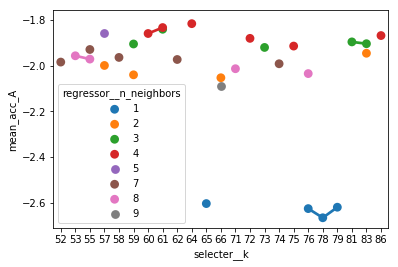

In [28]:
# open generated file with results of fitting GridSearchCV

sgrid = pd.read_csv(r'.\data_while_tuning\KNeighborsRegressor_'+target_trait+'_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()
#params_df['reg_params'] = params_df['regressor__algorithm'].values + params_df['regressor__weights'].values + params_df['regressor__n_neighbors'].values.astype(str)
#print(params_df.head())

# plot acc vs. params
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='regressor__n_neighbors', data=sgrid.join(params_df)) 

In [30]:
# update lists of tuning info and trained regressors
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

# save tuning_all (.csv) and trained_all (nameregressor.sav)
save_tuning(tuning_all, trained_all, target_trait)

#### Support Vector Machines

*class sklearn.svm.SVR(kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)*

For 'rbf': Tuning C (penalty of the error term) and gamma.

In [42]:
from sklearn.svm import SVR

"""
Support Vector Machines with rbf kernel
"""
def get_SVRrbf2tune():
    
    model = SVR()
    hp = dict(
        regressor__C = np.logspace(1,4,num=4),
        regressor__kernel = ['rbf'], 
        regressor__gamma = np.logspace(-3,-1,num=3)
    )
    return 'SVRrbf', model, hp

k_array = np.arange(50, AX.shape[1]+1)

# tune with rbf kernel
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_SVRrbf2tune], 
                           target_trait,
                           feats_names,
                           k_array, 
                           'random',
                           n_iter=15
                          )


'SVRrbf' -> Best cross-val score on A set: -1.548268 using {'selecter__k': 88, 'regressor__kernel': 'rbf', 'regressor__gamma': 0.01, 'regressor__C': 10.0}
'SVRrbf' -> root mean_squared_error on B set: 1.149177



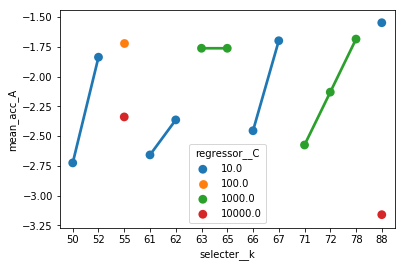

In [45]:
# open generated file with results of fitting GridSearchCV

sgrid = pd.read_csv(r'.\data_while_tuning\SVRrbf_'+target_trait+'_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()

# plot acc vs. params
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='regressor__C', data=sgrid.join(params_df)) 


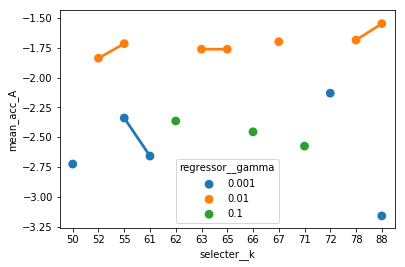

In [46]:
# plot acc vs. params
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='regressor__gamma', data=sgrid.join(params_df)) 

In [47]:
# update lists of tuning info and trained regressors
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

# save tuning_all (.csv) and trained_all (nameregressor.sav)
save_tuning(tuning_all, trained_all, target_trait)

#### Random Forest

*class sklearn.ensemble.RandomForestRegressor(n_estimators=10, criterion=’mse’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False)*

Tune: max_depth, min_samples_leaf. Max features taken are those given by the feature selection method.

In [8]:
from sklearn.ensemble import RandomForestRegressor

"""
Random Forest
"""
def get_RandomForestRegressor2tune():
    
    model = RandomForestRegressor(random_state=2302, max_features = None)
    hp = dict(
        regressor__max_depth = np.arange(2,50), 
        regressor__min_samples_leaf = np.arange(2,50) 
    )
    return 'RandomForestRegressor', model, hp

# feature selection
k_array = np.arange(30, 89)

# tune this model
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_RandomForestRegressor2tune], 
                           target_trait,
                           feats_names,
                           k_array, 
                           mode='random',
                           n_iter=50
                          )

'RandomForestRegressor' -> Best cross-val score on A set: -2.245015 using {'selecter__k': 86, 'regressor__min_samples_leaf': 5, 'regressor__max_depth': 41}
'RandomForestRegressor' -> root mean_squared_error on B set: 1.508458



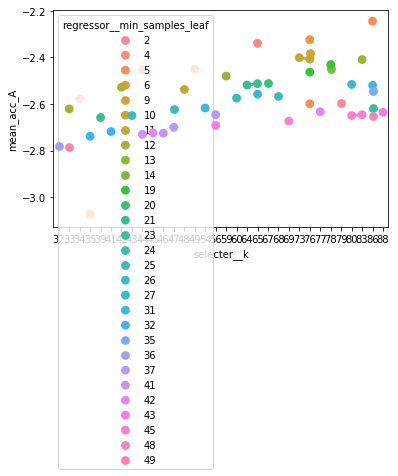

In [9]:
# open generated file with results of fitting GridSearchCV

sgrid = pd.read_csv(r'.\data_while_tuning\RandomForestRegressor_'+target_trait+'_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()

# plot acc vs. params
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='regressor__min_samples_leaf', data=sgrid.join(params_df)) 


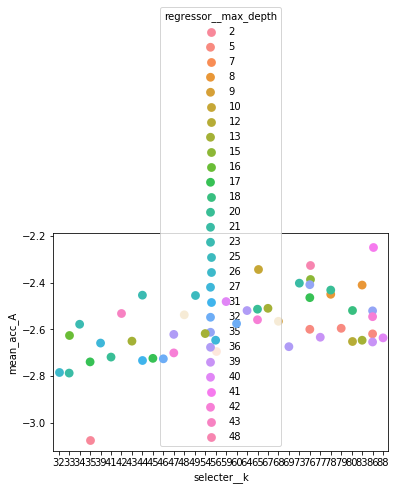

In [10]:
# plot acc vs. params
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='regressor__max_depth', data=sgrid.join(params_df)) 


In [11]:
from sklearn.ensemble import RandomForestRegressor

"""
Random Forest
"""
def get_RandomForestRegressor2tune():
    
    model = RandomForestRegressor(random_state=2302, max_features = None)
    hp = dict(
        regressor__max_depth = np.arange(40,60), 
        regressor__min_samples_leaf = np.arange(2,10) 
    )
    return 'RandomForestRegressor', model, hp

# tune this model (multiputput)
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_RandomForestRegressor2tune], 
                           target_trait,
                           feats_names,
                           k_array, 
                           mode='random',
                           n_iter=50
                          )

'RandomForestRegressor' -> Best cross-val score on A set: -2.211430 using {'selecter__k': 88, 'regressor__min_samples_leaf': 3, 'regressor__max_depth': 48}
'RandomForestRegressor' -> root mean_squared_error on B set: 1.512538



No improvement is found with RandomForestRegressor with respect to SVRrbf.

In [12]:
# update lists of tuning info and trained regressors
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

# save tuning_all (.csv) and trained_all (nameregressor.sav)
save_tuning(tuning_all, trained_all, target_trait)

Add baseline performance.

In [ ]:
from sklearn.dummy import DummyRegressor

model = DummyRegressor(strategy='mean')
model.fit(AX, Ay)
By_pred = model.predict(BX)
score_on_B = np.sqrt(mean_squared_error(By, By_pred))
d = {
    'regressors_names': ['DummyRegressor'],
    'best_accs': score_on_B,
    'best_hps': '',
    'sel_feats': '',
    'sel_feats_i': ''
    }

tuning = pd.DataFrame(data = d)
trained = model.fit(X, y)

# update lists of tuning info and trained regressors
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append([trained])

# save tuning_all (.csv) and trained_all (nameregressor.sav)
save_tuning(tuning_all, trained_all, target_trait)

## Testing

### RMSE
Testing the best model found after hyperparameter tuning.

Performance metric: RMSE.
    
The predictions correspond to the scores of each test segment (3 parts x 4 dialogs) spoken by the same test speaker. I perform the average of the predicted ratings that correspond to the same speaker - to be compared to the true ratings.

In [12]:
# select the classifier that gave the maximum acc on B set
best_accs = tuning_all['best_accs']
i_best = best_accs.idxmin()

print('Selected classifier based on the best performance on B: %r (perf. on B = %0.2f)' % (tuning_all.loc[i_best,'regressors_names'], round(best_accs[i_best],2)))

Selected classifier based on the best performance on B: 'SVRrbf' (perf. on B = 1.15)


In [13]:
# go through performace for all regressors

# removing duplicates from tuning_all (same classifier tuned twice with different searchers)
indexes = tuning_all['regressors_names'].drop_duplicates(keep='last').index.values

# dataframe for summary of performances
# performances = pd.DataFrame(tuning_all.loc[indexes,['regressors_names','best_accs']])

for i in indexes:

    yt_pred = trained_all[i][0].predict(Xt)
        
    # average of outputs that belong to the same speaker

    test_scores = pd.DataFrame(data = feats_ratings_scores_test[[target_trait,'spkID']])
    test_scores['pred'] = yt_pred

    test_scores_avg = test_scores.groupby('spkID').mean()

    myrmse = np.sqrt(mean_squared_error(test_scores[target_trait].as_matrix(), 
                 test_scores['pred'].as_matrix()))

    myrmse_avg = np.sqrt(mean_squared_error(test_scores_avg[target_trait].as_matrix(), 
                 test_scores_avg['pred'].as_matrix()))

    print('%r -> RMSE per instance on B: %0.2f' % (tuning_all.loc[i,'regressors_names'], tuning_all.loc[i,'best_accs']))   
    print('%r -> RMSE per instance: %0.2f' % (tuning_all.loc[i,'regressors_names'], myrmse))   
    print('%r -> RMSE after averaging over speaker utterances: %0.2f' % (tuning_all.loc[i,'regressors_names'], myrmse_avg))   


"'KNeighborsRegressor' -> RMSE per instance on B: 1.24
"'KNeighborsRegressor' -> RMSE per instance: 1.99
"'KNeighborsRegressor' -> RMSE after averaging over speaker utterances: 1.76
"'SVRrbf' -> RMSE per instance on B: 1.15
"'SVRrbf' -> RMSE per instance: 1.93
"'SVRrbf' -> RMSE after averaging over speaker utterances: 1.77
"'RandomForestRegressor' -> RMSE per instance on B: 1.51
"'RandomForestRegressor' -> RMSE per instance: 1.91
"'RandomForestRegressor' -> RMSE after averaging over speaker utterances: 1.77
"'DummyRegressor' -> RMSE per instance on B: 1.82
"'DummyRegressor' -> RMSE per instance: 1.98
"'DummyRegressor' -> RMSE after averaging over speaker utterances: 1.97


We just get an improvement from 2.0 (baseline) to ~1.9 (per instance) or ~1.77 (averaged per speaker)